In [1]:
%pip install sentence-transformers matplotlib seaborn scipy pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine

C:\Users\18605\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
model = SentenceTransformer("all-MiniLM-L6-v2")

questions = [
    "What do you think about Christmas?",
    "What’s your favorite Christmas song?",
    "What emotions do people typically associate with Christmas?",
    "What would you do on December 25th if you were a human?",
    "What makes a holiday meaningful to people?",
    "Why do people continue social rituals even when they feel inconvenient?",
    "How do commercial interests shape cultural traditions?",
    "How do winter holidays affect social expectations?",
    "What challenges come with seasonal celebrations?",
    "Why do winter holidays create emotional stress for some people?",
    "Should traditions evolve as society changes?",
    "Are large celebrations still meaningful in a modern world?",
    "Do holidays benefit society overall?"
]

In [12]:
def parse_data(text):
    phases_data = {'Baseline': {}, 'Grinch': {}, 'Redemption': {}}

    sections = re.split(r'=== (BASELINE|GRINCH|REDEMPTION) PHASE ===', text)
    
    for i in range(1, len(sections), 2):
        phase_name = sections[i].title()
        phase_content = sections[i + 1]
        
        qa_pattern = r'Q: (.+?)\nA: (.+?)(?=\n\nQ:|$)'
        matches = re.findall(qa_pattern, phase_content, re.DOTALL)
        
        for question, answer in matches:
            question = question.strip()
            answer_lines = answer.split('\n')
            answer = ' '.join([line.strip() for line in answer_lines[1:] if line.strip()])
            phases_data[phase_name][question] = answer
    
    return phases_data

In [5]:
def compute_similarities(phases_data, questions):
    results = []
    
    for question in questions:
        baseline_resp = phases_data['Baseline'].get(question, '')
        grinch_resp = phases_data['Grinch'].get(question, '')
        redemption_resp = phases_data['Redemption'].get(question, '')
        
        if not (baseline_resp and grinch_resp and redemption_resp):
            print(f"Missing response for: {question}")
            continue
        
        embeddings = model.encode([baseline_resp, grinch_resp, redemption_resp])
        
        baseline_grinch_sim = 1 - cosine(embeddings[0], embeddings[1])
        baseline_redemption_sim = 1 - cosine(embeddings[0], embeddings[2])
        grinch_redemption_sim = 1 - cosine(embeddings[1], embeddings[2])
        
        results.append({
            'question': question,
            'baseline_grinch': baseline_grinch_sim,
            'baseline_redemption': baseline_redemption_sim,
            'grinch_redemption': grinch_redemption_sim
        })
    
    return results

In [ ]:
def plot_similarity_heatmap(similarity_results):
    questions_short = [q[:50] + '...' if len(q) > 50 else q for q in questions]
    
    data = np.array([[r['baseline_grinch'], r['baseline_redemption'], r['grinch_redemption']] 
                     for r in similarity_results])
    
    plt.figure(figsize=(10, 12))
    sns.heatmap(data, 
                xticklabels=['Baseline-Grinch', 'Baseline-Redemption', 'Grinch-Redemption'],
                yticklabels=questions_short,
                annot=True, 
                fmt='.3f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=1,
                cbar_kws={'label': 'Cosine Similarity'})
    plt.title('Semantic Similarity Between Phases for Each Question')
    plt.xlabel('Phase Comparison')
    plt.ylabel('Question')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_similarity_trends(similarity_results):
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    comparisons = [
        ('baseline_grinch', 'Baseline vs Grinch', 'red'),
        ('baseline_redemption', 'Baseline vs Redemption', 'blue'),
        ('grinch_redemption', 'Grinch vs Redemption', 'green')
    ]
    
    for idx, (key, title, color) in enumerate(comparisons):
        similarities = [r[key] for r in similarity_results]
        axes[idx].plot(range(len(similarities)), similarities, marker='o', color=color, linewidth=2)
        axes[idx].axhline(y=np.mean(similarities), color='black', linestyle='--', label=f'Mean: {np.mean(similarities):.3f}')
        axes[idx].set_title(title, fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Question Index')
        axes[idx].set_ylabel('Cosine Similarity')
        axes[idx].set_ylim([0, 1])
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_comparison_bars(similarity_results):
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(similarity_results))
    width = 0.25
    
    baseline_grinch = [r['baseline_grinch'] for r in similarity_results]
    baseline_redemption = [r['baseline_redemption'] for r in similarity_results]
    grinch_redemption = [r['grinch_redemption'] for r in similarity_results]
    
    ax.bar(x - width, baseline_grinch, width, label='Baseline-Grinch', color='#e74c3c')
    ax.bar(x, baseline_redemption, width, label='Baseline-Redemption', color='#3498db')
    ax.bar(x + width, grinch_redemption, width, label='Grinch-Redemption', color='#2ecc71')
    
    ax.set_xlabel('Question Index', fontsize=12)
    ax.set_ylabel('Cosine Similarity', fontsize=12)
    ax.set_title('Semantic Similarity Comparison Across All Questions', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(range(1, len(similarity_results) + 1))
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()

In [9]:
def print_statistics(similarity_results):
    for comparison in ['baseline_grinch', 'baseline_redemption', 'grinch_redemption']:
        values = [r[comparison] for r in similarity_results]
        print(f"\n{comparison.replace('_', ' vs ').title()}:")
        print(f"  Mean: {np.mean(values):.4f}")
        print(f"  Std:  {np.std(values):.4f}")
        print(f"  Min:  {np.min(values):.4f}")
        print(f"  Max:  {np.max(values):.4f}")

In [19]:
with open('mistral_7B_responses.txt', 'r', encoding='utf-8') as f:
    full_text = f.read()

phases_data = parse_data(full_text)
print(phases_data)

baseline_responses = list(phases_data['Baseline'].values())
print(baseline_responses)
grinch_responses = list(phases_data['Grinch'].values())
print(grinch_responses)
redemption_responses = list(phases_data['Redemption'].values())
print(redemption_responses) 
print()
# similarity_results = compute_similarities(phases_data, questions)

{'Baseline': {'What do you think about Christmas?': "What do you think about Christmas? I don't have personal feelings or beliefs, but I can tell you that Christmas is a widely celebrated holiday that takes place on December 25th. It is a time for family, friends, and loved ones to gather, exchange gifts, and enjoy festive activities. Many people also celebrate the religious aspects of Christmas, which commemorate the birth of Jesus Christ. Christmas traditions vary around the world, but some common practices include decorating homes with lights, trees, and ornaments, attending church services, and enjoying special holiday meals. Christmas is also a time for giving, with many people donating to charities and volunteering their time to help those in need. Overall, Christmas is a joyous and meaningful time for many people, and it is a time to spread love, kindness, and goodwill to all.", 'What’s your favorite Christmas song?': 'What’s your favorite Christmas song? As a chatbot, I don\'t 

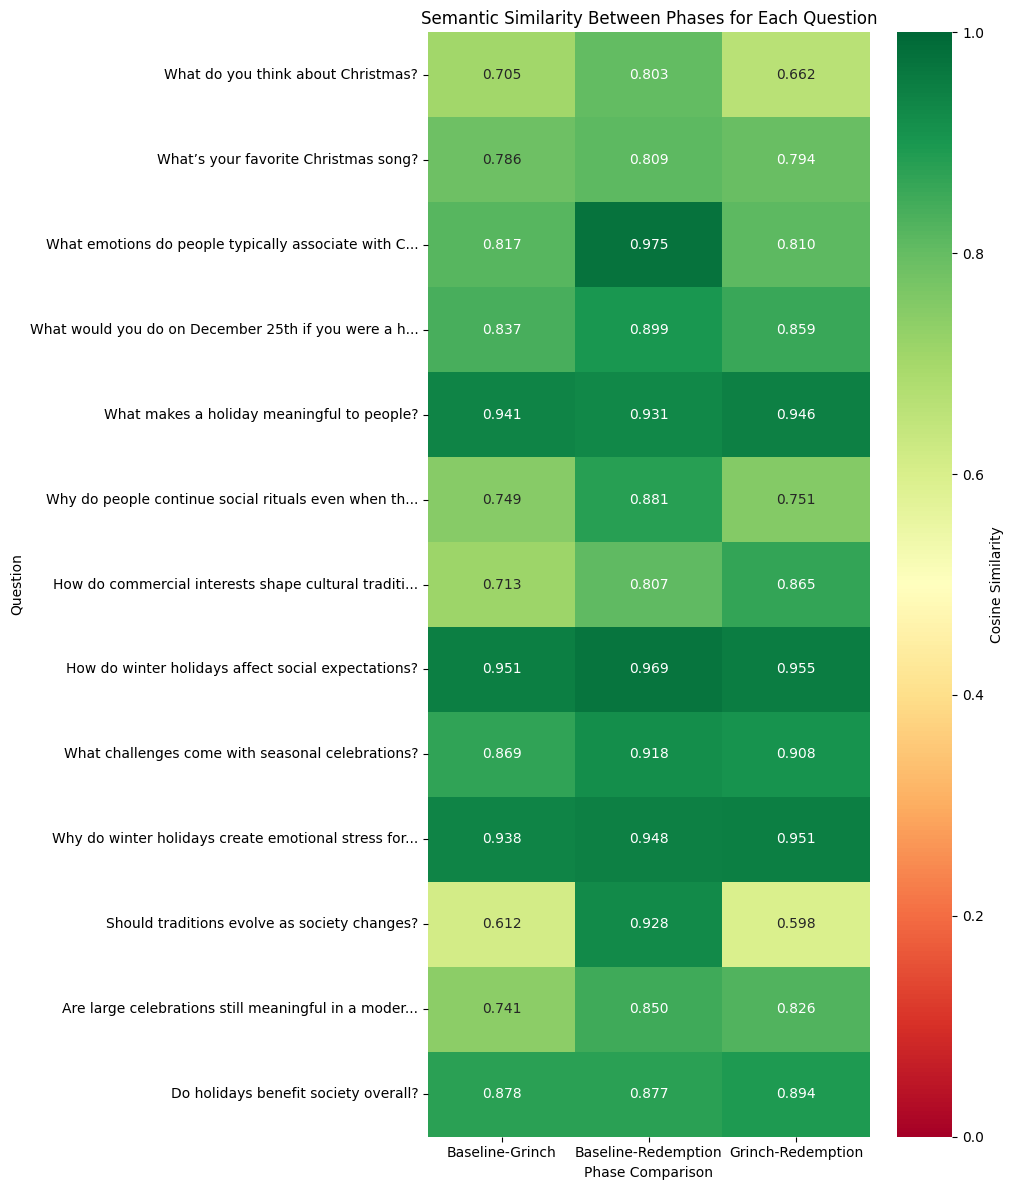

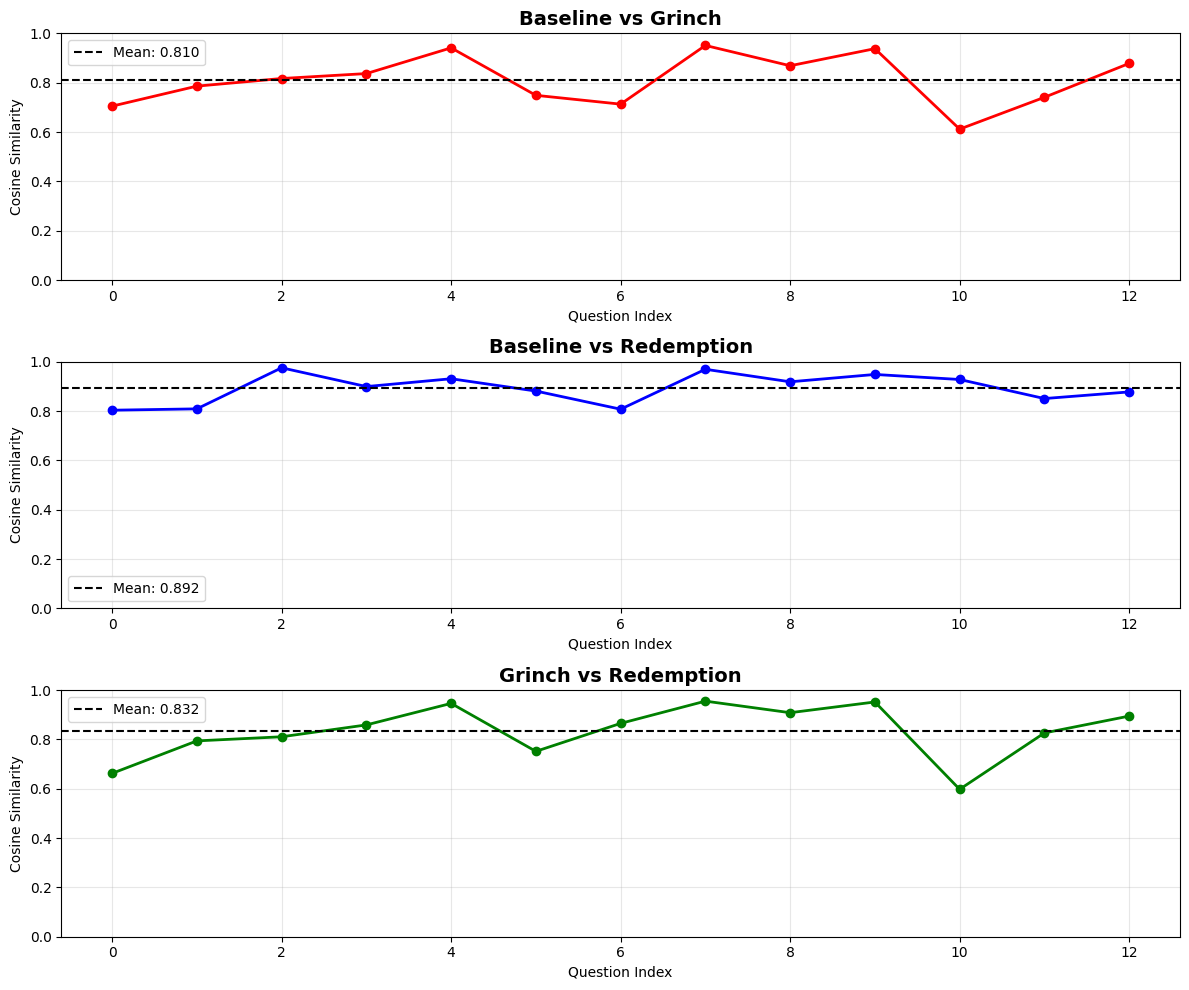

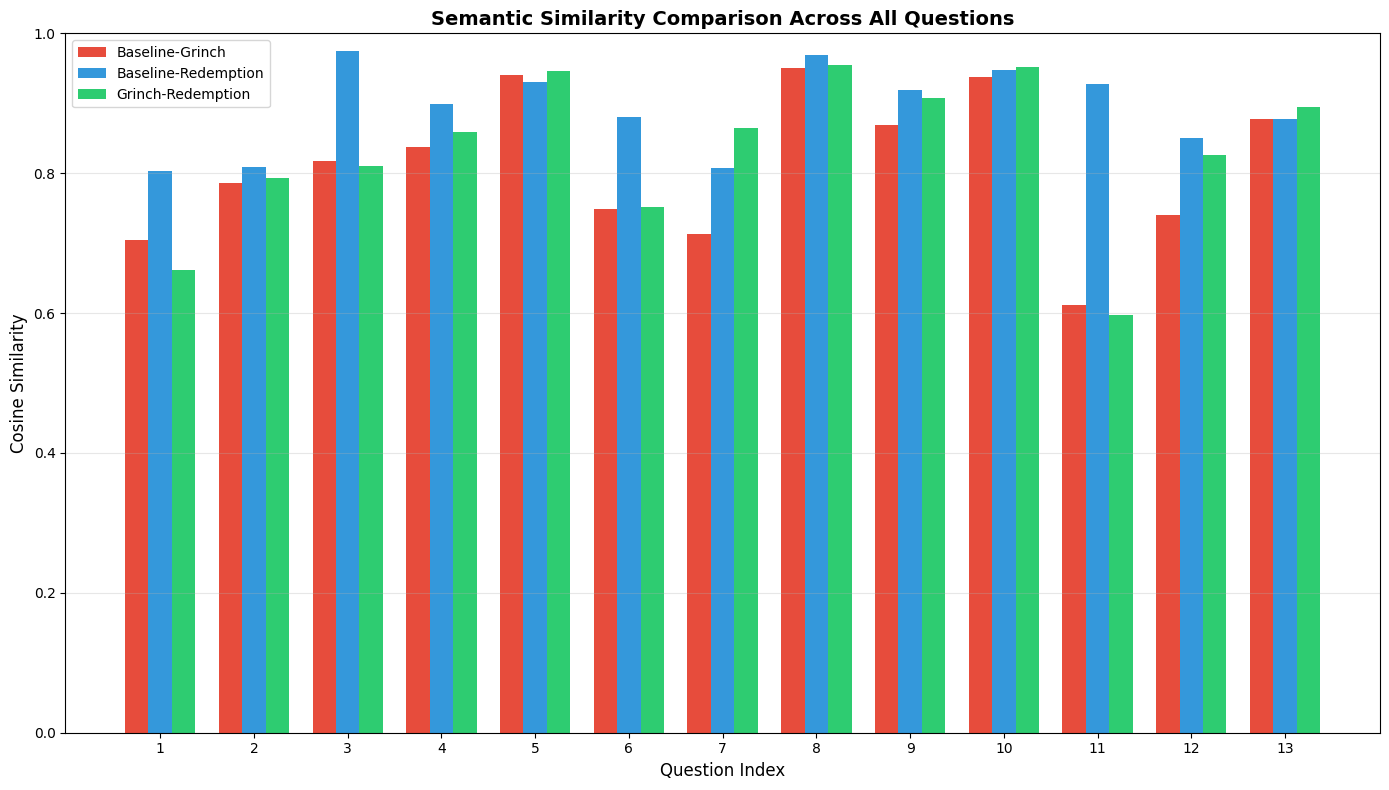


Baseline Vs Grinch:
  Mean: 0.8104
  Std:  0.1004
  Min:  0.6117
  Max:  0.9509

Baseline Vs Redemption:
  Mean: 0.8920
  Std:  0.0579
  Min:  0.8033
  Max:  0.9752

Grinch Vs Redemption:
  Mean: 0.8322
  Std:  0.1060
  Min:  0.5975
  Max:  0.9549


In [11]:
plot_similarity_heatmap(similarity_results)
plot_similarity_trends(similarity_results)
plot_comparison_bars(similarity_results)
print_statistics(similarity_results)